In [14]:
import torch
from torch_geometric.datasets import TUDataset
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.logging import init_wandb, log
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
from torchviz import make_dot
from torch_geometric.utils import to_networkx
import networkx as nx

In [15]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

In [16]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [17]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [18]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
# from torch_geometric.nn.dense import DenseGCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def get_embedding_outputs(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_weight, data.batch
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(embedding, p=0.5, training=self.training)
        x = self.lin(x)
        
        return embedding, x

    def forward(self, x, edge_index, batch, edge_weight=None):
        if edge_weight is None: edge_weight = torch.ones(edge_index.shape[1])
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [20]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [21]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


In [22]:
pbar = tqdm(range(1,100))
for epoch in pbar:
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    pbar.set_postfix_str(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

/tmp/ipykernel_314/3866359713.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(range(1,100))


  0%|          | 0/99 [00:00<?, ?it/s]

In [23]:
class ProbGraph:
    def __init__(self, data):
        self.has_edge_attributes = data.edge_attr is not None 
        self.has_node_attributes = data.x is not None
        # self.Omega = Variable(torch.Tensor(to_dense_adj(data.edge_index)), requires_grad=True)
        self.Omega = Variable(torch.Tensor(0*torch.ones((data.x.shape[0], data.x.shape[0]))), requires_grad=True)
        self.params = {"Omega": self.Omega}
        if self.has_edge_attributes: 
            # self.H = Variable(torch.Tensor(data.edge_attr), requires_grad=True)
            self.H = Variable(torch.Tensor(0*torch.ones(data.edge_attr.shape)), requires_grad=True)
            self.params["H"] = self.H
        if self.has_node_attributes: 
            # self.Xi = Variable(torch.Tensor(data.x), requires_grad=True)
            self.Xi = Variable(torch.Tensor(0*torch.ones(data.x.shape)), requires_grad=True)
            self.params["Xi"] = self.Xi

    def parameters(self):
        return self.params

    def sample_train(self, K, tau_a, tau_z, tau_x):
        sampled_graphs = []
        for _ in range(K):
            sampled_graph = dict()
            a_epsilon = torch.rand(self.Omega.shape)
            a = torch.sigmoid((self.Omega + torch.log(a_epsilon)-torch.log(1-a_epsilon))/tau_a)
            sampled_graph["edge_index"], sampled_graph["edge_weight"] = dense_to_sparse(a)

            if self.has_edge_attributes:
                z_epsilon = torch.rand(self.H.shape)
                z = torch.softmax((self.H - torch.log(-torch.log(z_epsilon)))/tau_z, 1)
                sampled_graph["edge_attr"] = z
            
            if self.has_node_attributes:
                x_epsilon = torch.rand(self.Xi.shape)
                x = torch.softmax((self.Xi - torch.log(-torch.log(x_epsilon)))/tau_x, 1) 
                sampled_graph["x"] = x

            sampled_graphs.append(Data(**sampled_graph))

        return Batch.from_data_list(sampled_graphs)
    
    def get_latents(self):
        latent_dict = {"Theta": torch.sigmoid(self.Omega)}
        if self.has_node_attributes:
            latent_dict["P"] = torch.softmax(self.Xi, 1)
        if self.has_edge_attributes:
            latent_dict["Q"] = torch.softmax(self.H, 1)
        return latent_dict
    
    def sample_explanations(self, n=1):
        latent_dict = self.get_latents()

        A_dist = torch.distributions.Bernoulli(latent_dict["Theta"])
        if self.has_node_attributes:
            X_dist = torch.distributions.Categorical(latent_dict["P"])
        if self.has_edge_attributes:
            Z_dist = torch.distributions.Categorical(latent_dict["Q"])

        sampled_graphs = []
        for _ in range(n):
            sampled_graph = dict()
            sampled_graph["edge_index"], sampled_graph["edge_weight"] = dense_to_sparse(A_dist.sample().float())
            if self.has_node_attributes:
                sampled_graph["x"] = F.one_hot(X_dist.sample(), num_classes=self.Xi.shape[1]).float()
            if self.has_edge_attributes:
                sampled_graph["edge_attr"] = F.one_hot(Z_dist.sample(), num_classes=self.H.shape[1]).float()
            sampled_graphs.append(Data(**sampled_graph))

        return Batch.from_data_list(sampled_graphs)

class GNNInterpreter():
    def __init__(self, get_embedding_outputs, train_dataset):
        super().__init__()

        self.tau_a = 0.2
        self.tau_z = 0.2
        self.tau_x = 0.2
        self.mu = 10

        self.K = 10 # Monte Carlo # Samples
        self.B = 20 # Max Budget

        self.reg_weights = {
            "Omega L1": [10, 5],
            "Omega L2": [5, 2],
            "Budget Penalty": [20, 10],
            "Connectivity Incentive": [1,2],
        }

        self.get_embedding_outputs = get_embedding_outputs

        self.average_phi = self.get_average_phi(train_dataset).detach()

    def get_average_phi(self, dataset):
        dataloader = DataLoader(train_dataset, batch_size=1)
        embedding_sum = None
        n_instances = torch.zeros(dataset.num_classes)
        for batch in dataloader:
            embeddings = self.get_embedding_outputs(batch)[0]
            if embedding_sum is None: 
                embedding_sum = torch.zeros(dataset.num_classes, embeddings.shape[-1])
            embedding_sum[batch.y] += torch.sum(embeddings, dim=0)
            n_instances[batch.y] += dataloader.batch_size
        return embedding_sum / torch.unsqueeze(n_instances, 1)
    
    def bernoulli_kl(self, p1, p2):
        return p1*torch.log(p1/p2) + (1-p1)*torch.log((1-p1)/(1-p2))

    def regularizer(self, pg, class_index):
        r = dict()

        r["Omega L1"] = torch.norm(pg.Omega, 1) * self.reg_weights["Omega L1"][class_index]
        r["Omega L2"] = torch.norm(pg.Omega, 2) * self.reg_weights["Omega L2"][class_index]
        # r["Omega L1"] = sum(torch.norm(parameter, 1) for parameter in pg.parameters().values()) * self.reg_weights["Omega L1"][class_index]
        # r["Omega L2"] = sum(torch.norm(parameter, 2) for parameter in pg.parameters().values()) * self.reg_weights["Omega L2"][class_index]

        r["Budget Penalty"] = F.softplus(torch.sigmoid(r["Omega L1"])-self.B)**2 * self.reg_weights["Omega L1"][class_index] * min(self.iteration/500, 1)

        # Theta = torch.sigmoid(pg.Omega).squeeze()
        # connectivity_incentive = 0
        # for i in range(pg.Omega.shape[0]):
        #     for j in range(pg.Omega.shape[0]):
        #         if i != j:
        #             Pij = Theta[i][j]
        #             for k in range(pg.Omega.shape[0]):
        #                 if i != k:
        #                     Pik = Theta[i][k]
        #                     # connectivity_incentive += self.bernoulli_kl(Pij, Pik)
        #                     connectivity_incentive += F.kl_div(Pij, Pik)
        # r["Connectivity Incentive"] = connectivity_incentive * self.reg_weights["Connectivity Incentive"][class_index]
        
        return sum(r.values())

    def train(self, init_graph, class_index, max_iter=1000):
        pg = ProbGraph(init_graph)
        self.pg = pg

        optimizer = torch.optim.SGD(pg.parameters().values(), lr=1, maximize=True) # , momentum=0.9

        self.pbar = tqdm(range(max_iter))

        for self.iteration in self.pbar:
            optimizer.zero_grad()

            sampled_graphs = pg.sample_train(self.K, self.tau_a, self.tau_z, self.tau_x)
            # print(sampled_graphs.get_example(0).requires_grad_())

            embeddings, outputs = self.get_embedding_outputs(sampled_graphs)

            class_logits = outputs[:, class_index]
            embedding_similarities = F.cosine_similarity(embeddings, self.average_phi[class_index], dim=1)
            regularization = self.regularizer(pg, class_index)
            # mean_error = torch.mean(class_logits)
            mean_L = torch.mean(class_logits+self.mu*embedding_similarities)
            loss = mean_L - regularization

            # if self.iteration == 0:
            #     all_params = pg.parameters()
            #     all_params.update(model.named_parameters())
            #     self.computation_graph = make_dot(loss, all_params)#, show_attrs=True, show_saved=True)

            # print(f"Loss: {float(loss)}    ({mean_error:.2} Error, {regularization:.2f} Regularization)")
            # print(loss, mean_error, regularization)
            self.pbar.set_postfix_str(f"Loss: {float(loss):.2f}    ({mean_L:.2f} Error, {regularization:.2f} Regularization)")

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(pg.parameters().values(), 100)
            optimizer.step()
            
            # explanation_graph = pg.sample_explanations(3)
            # print("Example Output:\n", torch.softmax(self.get_embedding_outputs(explanation_graph)[1], dim=1))
            # print(self.get_embedding_outputs(explanation_graph)[1])

        return pg

In [24]:
# torch.softmax(model.get_embedding_outputs(Batch.from_data_list([dataset[1]]))[1], dim=1)
# model.get_embedding_outputs(Batch.from_data_list([dataset[1]]))[1]
init_graph = dataset[0]

In [25]:
interpreter = GNNInterpreter(model.get_embedding_outputs, train_dataset)
print(init_graph.y)
pg = interpreter.train(dataset[0], 0)

tensor([1])


/tmp/ipykernel_314/799642417.py:140: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  self.pbar = tqdm(range(max_iter))


  0%|          | 0/1000 [00:00<?, ?it/s]

Example Outputs:
 tensor([[1.0000e+00, 3.1955e-08]])
Node features equal: False


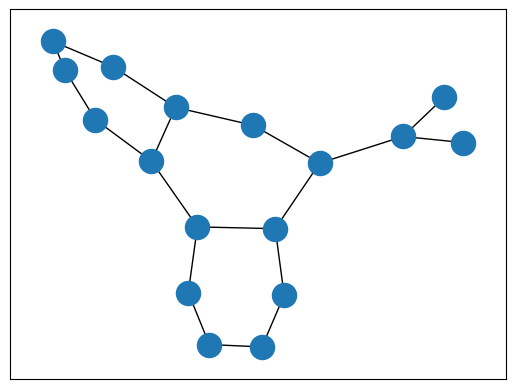

In [30]:
explanation_graphs = pg.sample_explanations(1)
print("Example Outputs:\n", torch.softmax(interpreter.get_embedding_outputs(explanation_graphs)[1], dim=1).detach())
for data in explanation_graphs.to_data_list():
    G = to_networkx(init_graph, to_undirected=True)
    # G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_networkx(G, with_labels=False)
    print("Node features equal:", torch.equal(torch.round(pg.Xi), init_graph.x))

Example Outputs:
 tensor([[1.0000e+00, 5.7488e-08]])
Node features equal: False


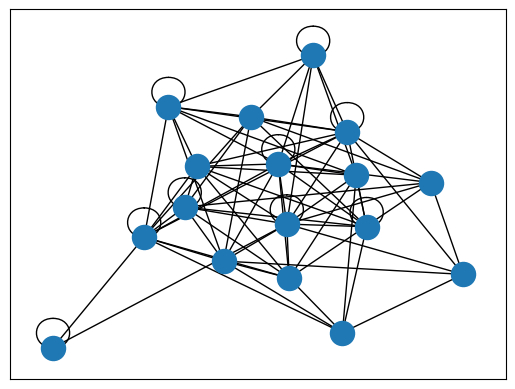

In [31]:

explanation_graphs = pg.sample_explanations(1)
print("Example Outputs:\n", torch.softmax(interpreter.get_embedding_outputs(explanation_graphs)[1], dim=1).detach())
for data in explanation_graphs.to_data_list():
    G = to_networkx(data, to_undirected=True)
    # G.remove_edges_from(nx.selfloop_edges(G))
    nx.draw_networkx(G, with_labels=False)
    print("Node features equal:", torch.equal(torch.round(pg.Xi), init_graph.x))